In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random

from sklearn import metrics
from collections import Counter
import argparse
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [2]:
data = pd.read_csv("dapps_with_features_v3.csv")

In [3]:
RS = 42
SPLITS = 5

In [4]:
X = data.drop('category', axis=1)
y = data.category

In [5]:
X, X_test, y, y_test  = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RS)

In [6]:
print(f'X_train shape {X.shape}')
print(f'X_test shape {X_test.shape}')

X_train shape (1716, 17)
X_test shape (430, 17)


# Training on code (no comments)

## Check for possible meta-parameters

In [8]:
length_SC = X.SC_no_comments.apply(lambda x: len(x.split()))

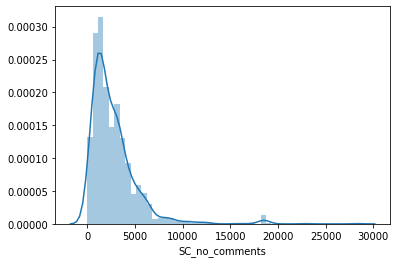

In [9]:
sns.distplot(length_SC)

In [10]:
length_SC.describe()

count     1716.000000
mean      2761.111888
std       2605.391686
min          5.000000
25%       1173.750000
50%       2070.000000
75%       3420.000000
max      28391.000000
Name: SC_no_comments, dtype: float64

In [11]:
X.SC_no_comments.str.split(expand=True).stack().value_counts()

newline                            2137095
}                                   125672
=                                   123624
{                                   120403
function                             92859
                                    ...   
SmsCertifier                             1
singleFillResult                         1
messageHash.recover(signature);          1
SafeMath.sub(_incomingHex,               1
gizerItemsContract;                      1
Length: 160755, dtype: int64

### Ridge

In [12]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS)

word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    #stop_words    = 'english',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [13]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 

# use best C

C_parameter = [1]

In [14]:
names = [f'aucroc_{i}' for i in ['development', 'exchanges', 'finance', 'gambling', 'games',
       'high-risk', 'marketplaces', 'media', 'other', 'social']]
names2 = [f'aucprc_{i}' for i in ['development', 'exchanges', 'finance', 'gambling', 'games',
       'high-risk', 'marketplaces', 'media', 'other', 'social']]
names.extend(names2)

In [15]:
for c_p in C_parameter:  
    metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
    for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)
             
            le = LabelBinarizer()
            le.fit(y_train)
            
            y_train = le.transform(y_train)
            y_val = le.transform(y_val)
            
            for i, cl in enumerate(le.classes_):
                classifier = LogisticRegression(C=c_p, solver='sag', random_state=RS)
                classifier.fit(train_word_features, y_train[:,i])
                probs      = classifier.predict_proba(val_word_features)[:,1]
                auc_roc_class = roc_auc_score(y_val[:,i], probs)
                auc_pr_class = average_precision_score(y_val[:,i], probs)
                
                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
                
    print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
    print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

C:1 AUC ROC: 0.909
C:1 AUC PRC: 0.618


In [16]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_development     0.884
aucroc_exchanges       0.977
aucroc_finance         0.945
aucroc_gambling        0.929
aucroc_games           0.940
aucroc_high-risk       0.953
aucroc_marketplaces    0.912
aucroc_media           0.869
aucroc_other           0.872
aucroc_social          0.810
dtype: float64

In [17]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_development     0.450
aucprc_exchanges       0.959
aucprc_finance         0.846
aucprc_gambling        0.768
aucprc_games           0.865
aucprc_high-risk       0.690
aucprc_marketplaces    0.607
aucprc_media           0.338
aucprc_other           0.451
aucprc_social          0.207
dtype: float64

In [18]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.834,0.971,0.914,0.923,0.933,0.922,0.878,0.868,0.855,0.802,0.297,0.949,0.767,0.807,0.891,0.604,0.560,0.292,0.422,0.277
1,0.912,0.991,0.959,0.921,0.929,0.965,0.907,0.865,0.814,0.790,0.490,0.977,0.894,0.662,0.806,0.737,0.700,0.399,0.330,0.127
2,0.931,0.988,0.965,0.923,0.948,0.934,0.923,0.866,0.879,0.835,0.481,0.971,0.882,0.806,0.883,0.744,0.547,0.214,0.478,0.184
3,0.914,0.979,0.966,0.918,0.959,0.973,0.956,0.908,0.900,0.780,0.613,0.967,0.890,0.765,0.887,0.601,0.659,0.227,0.541,0.128
4,0.831,0.956,0.919,0.959,0.929,0.973,0.894,0.839,0.914,0.841,0.368,0.932,0.797,0.800,0.857,0.763,0.568,0.559,0.485,0.317


In [19]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = LogisticRegression(C=c_p, solver='sag', random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [20]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.878,0.982,0.95,0.92,0.943,0.961,0.89,0.947,0.949,0.763,0.432,0.959,0.828,0.697,0.882,0.629,0.631,0.699,0.547,0.167


In [21]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.918
dtype: float64

In [22]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.647
dtype: float64

### Random Forest

In [23]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS)

word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [24]:
metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
for c, (train_index, val_index) in enumerate(kf.split(X, y)):

        X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
        y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
        word_vectorizer.fit(X_train)
        train_word_features = word_vectorizer.transform(X_train)
        val_word_features   = word_vectorizer.transform(X_val)

        le = LabelBinarizer()
        le.fit(y_train)

        y_train = le.transform(y_train)
        y_val = le.transform(y_val)

        
        classifier          = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
        classifier.fit(train_word_features, y_train)
        probs = classifier.predict_proba(val_word_features)
        
        for i, cl in enumerate(le.classes_):
            auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
            auc_pr_class = average_precision_score(y_val[:,i], probs[i][:,1])

            metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
            metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    3.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

C:1 AUC ROC: 0.91
C:1 AUC PRC: 0.613


[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.8s finished


In [25]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.845,0.957,0.927,0.938,0.933,0.951,0.901,0.875,0.865,0.826,0.317,0.928,0.790,0.813,0.881,0.637,0.568,0.341,0.522,0.251
1,0.894,0.983,0.964,0.937,0.917,0.973,0.833,0.800,0.813,0.804,0.303,0.964,0.894,0.691,0.818,0.699,0.677,0.336,0.335,0.125
2,0.886,0.983,0.971,0.948,0.945,0.957,0.892,0.916,0.914,0.898,0.389,0.958,0.900,0.825,0.885,0.720,0.473,0.278,0.608,0.332
3,0.883,0.978,0.952,0.930,0.961,0.974,0.953,0.900,0.909,0.859,0.497,0.963,0.874,0.782,0.900,0.623,0.628,0.246,0.514,0.241
4,0.839,0.954,0.918,0.957,0.927,0.959,0.867,0.821,0.913,0.803,0.322,0.925,0.780,0.783,0.839,0.668,0.575,0.535,0.515,0.165


In [26]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

for i, cl in enumerate(le.classes_):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    4.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.9s finished


In [27]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.934,0.982,0.954,0.93,0.951,0.966,0.905,0.906,0.925,0.788,0.438,0.968,0.855,0.738,0.908,0.665,0.688,0.566,0.603,0.279


In [28]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.924
dtype: float64

In [29]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.671
dtype: float64

### SVM

In [30]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l1']
alpha = [0.00001]
max_iter = [1000] 

for p in penalty:
  for a in alpha:
    for it in max_iter:
      auc = []
      roc = []
      fscore_ = []
      c = 0
      # print performance
      print(f'-------------')
      print(f'penalty {p}')
      print(f'alpha {a}')
      print(f'max_iter {i}')
      print(f'-------------')
      
    
      metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
      for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['SC_full'], X.iloc[val_index]['SC_full']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)
             
            le = LabelBinarizer()
            le.fit(y_train)
            
            y_train = le.transform(y_train)
            y_val = le.transform(y_val)
            
            for i, cl in enumerate(le.classes_):
                classifier = SGDClassifier(n_jobs=20, random_state=RS, loss='log', shuffle=False, 
                                    penalty=p, alpha=a, max_iter=it)
                classifier.fit(train_word_features, y_train[:,i])
                probs      = classifier.predict_proba(val_word_features)[:,1]
                auc_roc_class = roc_auc_score(y_val[:,i], probs)
                auc_pr_class = average_precision_score(y_val[:,i], probs)
                
                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
                
    print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
    print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l1
alpha 1e-05
max_iter 9
-------------
C:1 AUC ROC: 0.86
C:1 AUC PRC: 0.634


In [31]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.626,0.947,0.877,0.919,0.938,0.836,0.741,0.788,0.860,0.750,0.309,0.933,0.743,0.794,0.896,0.617,0.593,0.439,0.544,0.448
1,0.764,0.990,0.961,0.935,0.929,0.952,0.896,0.840,0.823,0.595,0.441,0.978,0.888,0.722,0.858,0.790,0.734,0.412,0.351,0.153
2,0.826,0.960,0.963,0.857,0.944,0.915,0.834,0.722,0.884,0.718,0.380,0.949,0.900,0.723,0.878,0.706,0.466,0.258,0.602,0.244
3,0.900,0.961,0.970,0.921,0.962,0.904,0.934,0.676,0.822,0.684,0.657,0.961,0.910,0.797,0.914,0.697,0.740,0.155,0.504,0.241
4,0.628,0.963,0.916,0.943,0.924,0.931,0.868,0.860,0.819,0.806,0.406,0.948,0.814,0.800,0.866,0.685,0.621,0.486,0.492,0.233


In [32]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_development     0.749
aucroc_exchanges       0.964
aucroc_finance         0.937
aucroc_gambling        0.915
aucroc_games           0.939
aucroc_high-risk       0.908
aucroc_marketplaces    0.855
aucroc_media           0.777
aucroc_other           0.842
aucroc_social          0.711
dtype: float64

In [33]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_development     0.439
aucprc_exchanges       0.954
aucprc_finance         0.851
aucprc_gambling        0.767
aucprc_games           0.882
aucprc_high-risk       0.699
aucprc_marketplaces    0.631
aucprc_media           0.350
aucprc_other           0.499
aucprc_social          0.264
dtype: float64

In [34]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['SC_full'])
train_word_features  = word_vectorizer.transform(X['SC_full'])
test_word_features   = word_vectorizer.transform(X_test['SC_full'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = SGDClassifier(n_jobs=20, random_state=RS, loss='log', shuffle=False, 
                                    penalty=penalty[0], alpha=alpha[0], max_iter=max_iter[0])
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [35]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.733,0.971,0.949,0.901,0.959,0.942,0.87,0.948,0.89,0.646,0.32,0.963,0.873,0.742,0.935,0.562,0.679,0.667,0.546,0.267
